In [8]:
import torch  # PyTorch kütüphanesini içe aktar
import torch.nn as nn  # Sinir ağı katmanları için gerekli modül
import torch.optim as optim  # Optimizasyon algoritmaları için modül
import torchvision  # Görüntü işleme için PyTorch'un modülü
import torchvision.transforms as transforms  # Görüntüleri dönüştürmek için modül
from torch.utils.data import DataLoader  # Verileri yüklemek için yardımcı sınıf
import matplotlib.pyplot as plt  # Görselleri göstermek için matplotlib

# Cihaz kontrolü: Eğer GPU varsa CUDA kullan, yoksa CPU kullan
# CUDA, GPU'ları kullanarak işlemleri hızlandırır
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
# MNIST veri kümesini yükleme ve dönüştürme
# MNIST, el yazısı rakamları içeren bir veri kümesidir
transform = transforms.Compose([
    transforms.ToTensor(),  # Görüntüleri tensörlere (PyTorch'un anladığı formata) çevir
    transforms.Normalize((0.5,), (0.5,))  # Verileri normalize et (ortalama 0.5, std 0.5)
])  


# Eğitim ve test veri kümelerini indir ve uygula
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Verileri mini partilere bölerek işleyebilmek için DataLoader kullan
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Eğitim verisi
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # Test verisi




In [ ]:
# Eğitim veri kümesinin bir kısmını görüntüleme
examples = iter(train_loader)
images, labels = next(examples)

print("Örnek Görüntülerin Sayısal Değerleri (İlk 6 Görüntü):")
for i in range(6):
    print(f'Label: {labels[i].item()}')
    print(images[i].squeeze().numpy())  # Tensörü numpy dizisine çevirerek yazdır
    print("-" * 50)

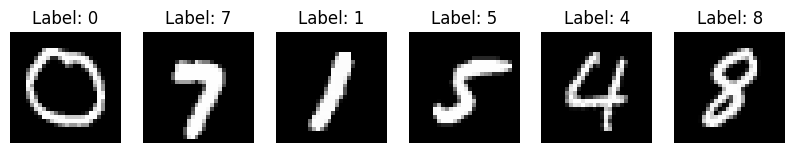

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(10, 3))  # 1 satırda 6 resim göster
for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap='gray')  # Görüntüyü gri tonlamada göster
    axes[i].set_title(f'Label: {labels[i].item()}')
    axes[i].axis('off')
plt.show()

In [12]:
# Basit bir sinir ağı modeli oluşturma
class SimpleNN(nn.Module):  # PyTorch'un nn.Module sınıfından türetilmiş bir model
    def __init__(self):  # Modelin katmanlarını burada tanımlıyoruz
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # İlk katman: 28x28 giriş -> 128 nöron
        self.relu = nn.ReLU()  # Aktivasyon fonksiyonu: ReLU (negatifleri sıfırlar)
        self.fc2 = nn.Linear(128, 10)  # Çıkış katmanı: 128 giriş -> 10 çıkış (0-9 rakamları)
    
    def forward(self, x):  # Modelin ileri yönlü hesaplama fonksiyonu
        x = x.view(-1, 28*28)  # 28x28 görüntüyü düzleştirerek tek boyutlu hale getir
        x = self.fc1(x)  # İlk tam bağlı katmandan geçir
        x = self.relu(x)  # Aktivasyon fonksiyonunu uygula
        x = self.fc2(x)  # Son katmandan geçir
        return x  # Çıkışı döndür

In [13]:
# Modeli oluştur ve cihazda çalıştır (CPU/GPU fark etmeksizin çalışır)
model = SimpleNN().to(device)

# Kayıp fonksiyonu ve optimizer tanımlama
# Kayıp fonksiyonu: CrossEntropyLoss (çok sınıflı sınıflandırmada yaygın)
# Optimizasyon algoritması: Adam (hızlı ve etkili bir optimizasyon yöntemi)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Modeli eğitme
epochs = 5  # Modeli kaç defa tüm veri kümesi üzerinde eğiteceğimiz
for epoch in range(epochs):  # Her epoch bir tam eğitim turudur
    model.train()  # Modeli eğitim moduna al
    running_loss = 0.0  # Kümülatif hata değerini tutmak için değişken
    for images, labels in train_loader:  # Eğitim verisi üzerinde döngü
        images, labels = images.to(device), labels.to(device)  # Verileri cihaza yükle
        
        optimizer.zero_grad()  # Önceki hesaplanan gradyanları sıfırla
        outputs = model(images)  # Modelden tahmin al
        loss = criterion(outputs, labels)  # Gerçek değerlerle kıyaslayarak hata hesapla
        loss.backward()  # Hatanın gradyanlarını hesapla
        optimizer.step()  # Ağırlıkları güncelle
        
        running_loss += loss.item()  # Toplam hatayı güncelle
    
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')  # Epoch başına hata değerini yazdır


Epoch 1, Loss: 0.3782685935370195
Epoch 2, Loss: 0.18694403283059724
Epoch 3, Loss: 0.13318857013273722
Epoch 4, Loss: 0.1079068005716464
Epoch 5, Loss: 0.09207491204341146


In [14]:
# Modeli test etme
model.eval()  # Modeli test moduna al (bazı katmanlar farklı çalışabilir)
correct = 0  # Doğru tahmin sayısını tutan değişken
total = 0  # Toplam örnek sayısı
torch.no_grad()  # Modeli test ederken gradyan hesaplamasını kapat (hızlı çalışsın)
with torch.no_grad():
    for images, labels in test_loader:  # Test verisi üzerinde döngü
        images, labels = images.to(device), labels.to(device)  # Verileri cihaza yükle
        outputs = model(images)  # Modelden tahmin al
        _, predicted = torch.max(outputs, 1)  # En yüksek olasılığa sahip sınıfı al
        total += labels.size(0)  # Toplam veri sayısını güncelle
        correct += (predicted == labels).sum().item()  # Doğru tahminleri say

# Modelin doğruluk oranını ekrana yazdır
print(f'Accuracy: {100 * correct / total:.2f}%')  # Yüzde olarak doğruluk oranı hesapla

Accuracy: 97.23%
